Among all the built ML models Logistic Regression showed the best results. It had an F score of 45%. F-measure was chosen due to the dataset imbalance and the importance to minimize false negatives while false positives were still significant. The result of the F score was not ideal. It indicated that the model's performance was below average, and neural networks were tried out to improve the accuracy of the predictions.

Neural networks have been used extensively in natural language processing and they provide powerful new tools for modeling language. They are applied to many language problems: unsupervised learning of word representations, supervised text classification, language modeling, etc. They are well suited for learning the complex underlying structure of a sentence and semantic proximity of various words. Neural networks are much more flexible than other ML models, as they allow to easily experiment with different structures, adding and removing layers as needed. Neural networks are also easy to train as new data comes in.

## Part II
## Data Preparation and Exploration
Before building neural networks, several preprocessing steps were required.

In [122]:
# Import all required packages
import pandas as pd
import numpy
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore')

In [123]:
# Import data and inspect it

X_train_final = pd.read_csv('Data/X_train_final.csv')
X_train_final.head()

,lemmatized_text
0,apple set open popoup shop austin link
1,download innovative immersive history lesson q...
2,apple school marketing expert cnet link
3,tip day turn iphone screen brightness way
4,check game iphone android seem pretty cool


In [124]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6545 entries, 0 to 6544
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lemmatized_text  6543 non-null   object
dtypes: object(1)
memory usage: 51.3+ KB


In [33]:
X_val = pd.read_csv('Data/X_val.csv')
X_val.head()

,lemmatized_text
0,droid surprise rt spot table three people phon...
1,google try fill void local information hotpot ...
2,actually idea could google fine knowing
3,get temporary apple set temporary store austin...
4,rt link samsung galaxy ii appear fcc team andr...


In [34]:
X_test = pd.read_csv('Data/X_test.csv')
X_test.head()

,lemmatized_text
0,google close launch new social network circle ...
1,iphone charge link
2,walk lady bird lake lovely google map travel t...
3,ûï rumor apple popup store downtown austin amp...
4,rt google launch major new social network call...


In [35]:
y_train_final = pd.read_csv('Data/y_train_final.csv')
y_val = pd.read_csv('Data/y_val.csv')
y_test = pd.read_csv('Data/y_test.csv')

In [76]:
# Use one-hot encoding to reformat the complaints into a matrix of vectors
# Only keep the 2000 most common words
tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(X_train_final)
X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode='binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='binary')

In [92]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)
y_train_lb = to_categorical(lb.transform(y_train_final), num_classes=3)[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val), num_classes=3)[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test), num_classes=3)[:, :, 1]

In [93]:
# Estimate class weights
from sklearn.utils import compute_class_weight
import numpy as np
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train_final),
                                     y = y_train_final.values.reshape(-1))
                                     
class_weights = dict(zip(np.unique(y_train_final), class_weights))
class_weights

{'Negative emotion': 5.413564929693962,
 'Neutral emotion': 0.5448717948717948,
 'Positive emotion': 1.0204240723417524}

In [94]:
# Build a baseline neural network model
random.seed(123)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation='relu', input_shape=(2500,)))
baseline_model.add(layers.Dense(25, activation='relu'))
baseline_model.add(layers.Dense(3, activation='softmax'))

In [95]:
# Compile the model
import keras
baseline_model.compile(optimizer='SGD',
                       loss='categorical_crossentropy',
                       metrics=['accuracy',
                                keras.metrics.Precision(name='precision', class_id=0),
                                keras.metrics.Recall(name='recall', class_id=0)])

In [121]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6545 entries, 0 to 6544
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lemmatized_text  6543 non-null   object
dtypes: object(1)
memory usage: 51.3+ KB


In [106]:
# Train the model
weights = {0: 5.41356, 1: 0.54487, 2: 1.02042}
baseline_model_val = baseline_model.fit(X_train_tokens,
                                        y_train_lb,
                                        class_weight=weights,
                                        epochs=250,
                                        batch_size=256,
                                        validation_data=(X_val_tokens, y_val_lb))

ValueError: Data cardinality is ambiguous:
  x sizes: 1
  y sizes: 6545
Make sure all arrays contain the same number of samples.

In [101]:
baseline_model_val_dict = baseline_model_val.history
baseline_model_val_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [117]:
results_train = baseline_model.evaluate(X_train_tokens, y_train_lb)
print('-------------')
print(f'Training Loss: {results_train[0]:.3} \
       Training Accuracy: {results_train[1]:.3} \
       Training Precision: {results_train[2]:.3} \
       Training Recall: {results_train[3]:.3}')

171/171 [==============================] - 1s 8ms/step - loss: 0.2863 - accuracy: 0.8970 - precision: 0.9083 - recall: 1.0000
-------------
Training Loss: 0.286        Training Accuracy: 0.897        Training Precision: 0.908        Training Recall: 1.0


In [118]:
def find_f_score(precision, recall, beta):
    f_score = (1+beta**2)*(precision*recall)/((beta**2*precision)+recall)
    return f_score

In [120]:
training_f_score = find_f_score(precision=0.908, recall=1, beta=2)
training_f_score

0.9801381692573403

In [121]:
results_test = baseline_model.evaluate(X_test_tokens, y_test_lb)
print('-------------')
print(f'Test Loss: {results_test[0]:.3} \
        Test Accuracy: {results_test[1]:.3} \
        Test Precision: {results_test[2]:.3} \
        Test Recall: {results_test[3]:.3}')

72/72 [==============================] - 1s 9ms/step - loss: 0.9043 - accuracy: 0.6533 - precision: 0.4309 - recall: 0.3510
-------------
Test Loss: 0.904         Test Accuracy: 0.653         Test Precision: 0.431         Test Recall: 0.351


In [123]:
test_f_score = find_f_score(precision=0.431, recall=0.351, beta=2)
test_f_score

0.36453253012048187

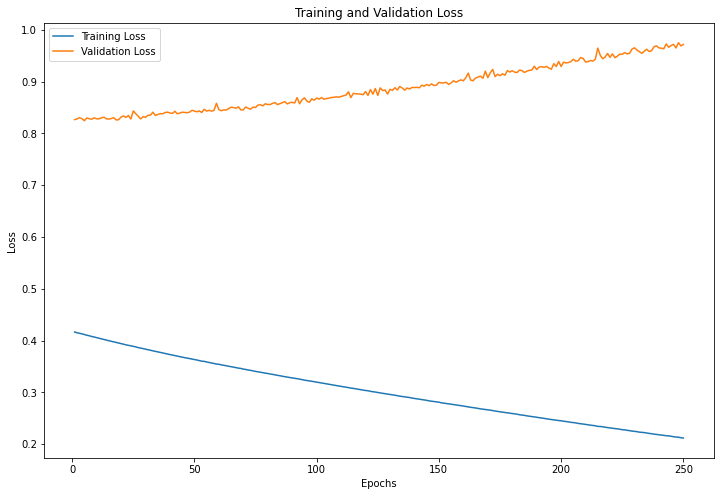

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))
baseline_model_val_dict = baseline_model_val.history
loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']
epochs = range(1, len(loss_values)+1)
ax.plot(epochs, loss_values, label='Training Loss')
ax.plot(epochs, val_loss_values, label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

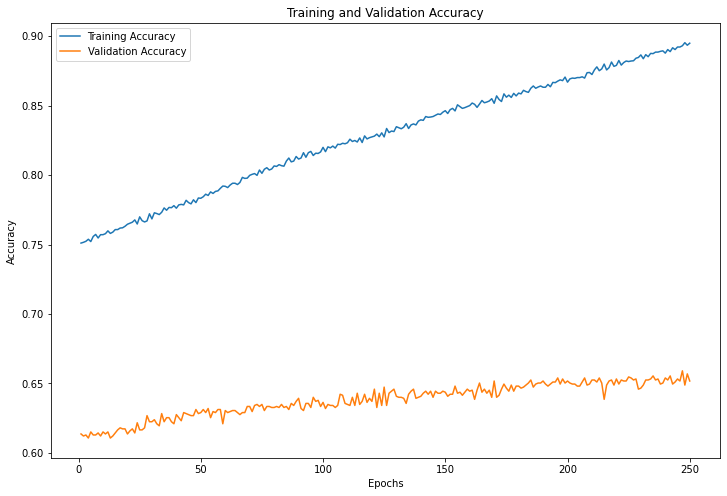

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))
acc_values = baseline_model_val_dict['accuracy']
val_acc_values = baseline_model_val_dict['val_accuracy']
ax.plot(epochs, acc_values, label='Training Accuracy')
ax.plot(epochs, val_acc_values, label='Validation Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

There is an interesting pattern here. Although the training sccuracy keeps increasing when going through more epochs, and the training loss kepps decreasing, the validation accuracy and loss don't necessarily do teh same. After a certain point, validation accuracy keeps swinging, which means that the model is probably overfit.

In [126]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model_2.add(layers.Dense(25, activation='relu'))
model_2.add(layers.Dense(3, activation='softmax'))

model_2.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy',
                         keras.metrics.Precision(name='precision', class_id=0),
                         keras.metrics.Recall(name='recall', class_id=0)])

In [127]:
# patience: Number of epochs with no improvement after which training will be stopped.
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = [EarlyStopping(monitor='val_loss', patience=15),
                  ModelCheckpoint(filepath='best_model.h5',
                                  monitor='val_loss',
                                  save_best_only=True)]

In [128]:
model_2_val = model_2.fit(X_train_tokens,
                          y_train_lb,
                          class_weight=weights,
                          epochs=250,
                          callbacks=early_stopping,              
                          batch_size=256,
                          validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250
 5/22 [=====>........................] - ETA: 0s - loss: 1.1676 - accuracy: 0.5656 - precision: 0.0000e+00 - recall: 0.0000e+00 

2023-03-20 13:53:35.314307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 28ms/step - loss: 1.1024 - accuracy: 0.5659 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0622 - val_accuracy: 0.5543 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/250
 1/22 [>.............................] - ETA: 0s - loss: 1.1025 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-03-20 13:53:35.851589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 13ms/step - loss: 1.0998 - accuracy: 0.5501 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0665 - val_accuracy: 0.5242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/250
22/22 [==============================] - 0s 12ms/step - loss: 1.0976 - accuracy: 0.5419 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0700 - val_accuracy: 0.5110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/250
22/22 [==============================] - 0s 12ms/step - loss: 1.0956 - accuracy: 0.5324 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0724 - val_accuracy: 0.4978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/250
22/22 [==============================] - 0s 13ms/step - loss: 1.0938 - accuracy: 0.5043 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0739 - val_accuracy: 0.4949 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/250
22/22 [==============================] -

22/22 [==============================] - 0s 12ms/step - loss: 0.8775 - accuracy: 0.5318 - precision: 0.3446 - recall: 0.6239 - val_loss: 0.9579 - val_accuracy: 0.4905 - val_precision: 0.2740 - val_recall: 0.4348
Epoch 73/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8744 - accuracy: 0.5311 - precision: 0.3393 - recall: 0.6391 - val_loss: 0.9483 - val_accuracy: 0.4978 - val_precision: 0.2868 - val_recall: 0.4239
Epoch 74/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8710 - accuracy: 0.5384 - precision: 0.3492 - recall: 0.6269 - val_loss: 0.9572 - val_accuracy: 0.4912 - val_precision: 0.2667 - val_recall: 0.4348
Epoch 75/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8677 - accuracy: 0.5377 - precision: 0.3431 - recall: 0.6422 - val_loss: 0.9555 - val_accuracy: 0.4941 - val_precision: 0.2685 - val_recall: 0.4348
Epoch 76/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8640 - accuracy: 0.5357 - precision:

22/22 [==============================] - 0s 12ms/step - loss: 0.6352 - accuracy: 0.6420 - precision: 0.5034 - recall: 0.9144 - val_loss: 0.8578 - val_accuracy: 0.5711 - val_precision: 0.3284 - val_recall: 0.4783
Epoch 145/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6318 - accuracy: 0.6480 - precision: 0.5175 - recall: 0.9052 - val_loss: 0.8778 - val_accuracy: 0.5609 - val_precision: 0.3067 - val_recall: 0.5000
Epoch 146/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6288 - accuracy: 0.6456 - precision: 0.5154 - recall: 0.9235 - val_loss: 0.8605 - val_accuracy: 0.5711 - val_precision: 0.3139 - val_recall: 0.4674
Epoch 147/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6259 - accuracy: 0.6478 - precision: 0.5219 - recall: 0.9113 - val_loss: 0.8625 - val_accuracy: 0.5704 - val_precision: 0.3214 - val_recall: 0.4891
Epoch 148/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6228 - accuracy: 0.6511 - precis

22/22 [==============================] - 0s 12ms/step - loss: 0.4663 - accuracy: 0.7241 - precision: 0.7028 - recall: 0.9908 - val_loss: 0.8197 - val_accuracy: 0.6114 - val_precision: 0.3564 - val_recall: 0.3913
Epoch 217/250
22/22 [==============================] - 0s 12ms/step - loss: 0.4648 - accuracy: 0.7270 - precision: 0.7083 - recall: 0.9878 - val_loss: 0.8259 - val_accuracy: 0.6100 - val_precision: 0.3458 - val_recall: 0.4022
Epoch 218/250
22/22 [==============================] - 0s 12ms/step - loss: 0.4631 - accuracy: 0.7280 - precision: 0.7130 - recall: 0.9878 - val_loss: 0.8251 - val_accuracy: 0.6085 - val_precision: 0.3491 - val_recall: 0.4022
Epoch 219/250
22/22 [==============================] - 0s 12ms/step - loss: 0.4615 - accuracy: 0.7243 - precision: 0.7090 - recall: 0.9908 - val_loss: 0.8233 - val_accuracy: 0.6122 - val_precision: 0.3585 - val_recall: 0.4130
Epoch 220/250
22/22 [==============================] - 0s 13ms/step - loss: 0.4600 - accuracy: 0.7269 - precis

In [130]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

In [131]:
results_train = saved_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \
        Training Accuracy: {results_train[1]:.3} \
        Training Precision: {results_train[2]:.3} \
        Training Recall: {results_train[3]:.3}')
print('-------------')
results_test = saved_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \
        Test Accuracy: {results_test[1]:.3} \
        Test Precision: {results_test[2]:.3} \
        Test Recall: {results_test[3]:.3}')

  6/171 [>.............................] - ETA: 1s - loss: 0.6190 - accuracy: 0.7188 - precision: 0.8095 - recall: 1.0000 

2023-03-20 13:56:48.484720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 2s 8ms/step - loss: 0.5984 - accuracy: 0.7239 - precision: 0.7358 - recall: 0.9878
Training Loss: 0.598         Training Accuracy: 0.724         Training Precision: 0.736         Training Recall: 0.988
-------------
72/72 [==============================] - 1s 8ms/step - loss: 0.8082 - accuracy: 0.6014 - precision: 0.3663 - recall: 0.4172
Test Loss: 0.808         Test Accuracy: 0.601         Test Precision: 0.366         Test Recall: 0.417


In [132]:
test_f_score = find_f_score(precision=0.366, recall=0.417, beta=2)
test_f_score

0.4056937799043062

In [133]:
from keras import regularizers
random.seed(123)
L2_model = models.Sequential()
L2_model.add(layers.Dense(50, 
                          activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005),
                          input_shape=(2000,)))
L2_model.add(layers.Dense(25,
                          kernel_regularizer=regularizers.l2(0.005),
                          activation='relu'))
L2_model.add(layers.Dense(3, activation='softmax'))

L2_model.compile(optimizer='SGD',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 
                          keras.metrics.Precision(name='precision', class_id=0),
                          keras.metrics.Recall(name='recall', class_id=0)])

In [134]:
L2_model_val = L2_model.fit(X_train_tokens,
                            y_train_lb,
                            class_weight=weights,
                            epochs=250,        
                            batch_size=256,
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250


2023-03-20 13:58:13.894079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 27ms/step - loss: 1.7536 - accuracy: 0.5677 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7139 - val_accuracy: 0.5469 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/250
 1/22 [>.............................] - ETA: 0s - loss: 1.7890 - accuracy: 0.5898 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-03-20 13:58:14.522266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 13ms/step - loss: 1.7479 - accuracy: 0.5421 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7153 - val_accuracy: 0.5176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/250
22/22 [==============================] - 0s 12ms/step - loss: 1.7429 - accuracy: 0.5289 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7154 - val_accuracy: 0.5081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/250
22/22 [==============================] - 0s 12ms/step - loss: 1.7381 - accuracy: 0.5192 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7156 - val_accuracy: 0.4883 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/250
22/22 [==============================] - 0s 12ms/step - loss: 1.7335 - accuracy: 0.4900 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7144 - val_accuracy: 0.4773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/250
22/22 [==============================] -

22/22 [==============================] - 0s 13ms/step - loss: 1.3868 - accuracy: 0.5237 - precision: 0.3426 - recall: 0.5627 - val_loss: 1.4529 - val_accuracy: 0.4927 - val_precision: 0.2836 - val_recall: 0.4130
Epoch 73/250
22/22 [==============================] - 0s 12ms/step - loss: 1.3822 - accuracy: 0.5239 - precision: 0.3345 - recall: 0.5627 - val_loss: 1.4534 - val_accuracy: 0.4853 - val_precision: 0.2746 - val_recall: 0.4239
Epoch 74/250
22/22 [==============================] - 0s 12ms/step - loss: 1.3771 - accuracy: 0.5179 - precision: 0.3322 - recall: 0.6055 - val_loss: 1.4392 - val_accuracy: 0.5029 - val_precision: 0.3033 - val_recall: 0.4022
Epoch 75/250
22/22 [==============================] - 0s 12ms/step - loss: 1.3727 - accuracy: 0.5283 - precision: 0.3497 - recall: 0.5872 - val_loss: 1.4438 - val_accuracy: 0.4883 - val_precision: 0.2899 - val_recall: 0.4348
Epoch 76/250
22/22 [==============================] - 0s 12ms/step - loss: 1.3679 - accuracy: 0.5261 - precision:

22/22 [==============================] - 0s 12ms/step - loss: 1.0783 - accuracy: 0.6238 - precision: 0.4774 - recall: 0.8716 - val_loss: 1.2689 - val_accuracy: 0.5579 - val_precision: 0.3259 - val_recall: 0.4783
Epoch 145/250
22/22 [==============================] - 0s 12ms/step - loss: 1.0743 - accuracy: 0.6282 - precision: 0.4895 - recall: 0.8563 - val_loss: 1.2829 - val_accuracy: 0.5499 - val_precision: 0.2973 - val_recall: 0.4783
Epoch 146/250
22/22 [==============================] - 0s 12ms/step - loss: 1.0710 - accuracy: 0.6255 - precision: 0.4725 - recall: 0.8685 - val_loss: 1.2674 - val_accuracy: 0.5594 - val_precision: 0.3212 - val_recall: 0.4783
Epoch 147/250
22/22 [==============================] - 0s 12ms/step - loss: 1.0670 - accuracy: 0.6299 - precision: 0.4897 - recall: 0.8716 - val_loss: 1.2577 - val_accuracy: 0.5623 - val_precision: 0.3308 - val_recall: 0.4674
Epoch 148/250
22/22 [==============================] - 0s 13ms/step - loss: 1.0632 - accuracy: 0.6328 - precis

22/22 [==============================] - 0s 12ms/step - loss: 0.8619 - accuracy: 0.6933 - precision: 0.6618 - recall: 0.9633 - val_loss: 1.1614 - val_accuracy: 0.5953 - val_precision: 0.3419 - val_recall: 0.4348
Epoch 217/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8593 - accuracy: 0.6900 - precision: 0.6590 - recall: 0.9633 - val_loss: 1.1597 - val_accuracy: 0.6004 - val_precision: 0.3417 - val_recall: 0.4457
Epoch 218/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8569 - accuracy: 0.6931 - precision: 0.6556 - recall: 0.9664 - val_loss: 1.1553 - val_accuracy: 0.5997 - val_precision: 0.3448 - val_recall: 0.4348
Epoch 219/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8545 - accuracy: 0.6940 - precision: 0.6625 - recall: 0.9664 - val_loss: 1.1547 - val_accuracy: 0.5982 - val_precision: 0.3419 - val_recall: 0.4348
Epoch 220/250
22/22 [==============================] - 0s 12ms/step - loss: 0.8522 - accuracy: 0.6939 - precis

In [135]:
results_train = L2_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \
        Training Accuracy: {results_train[1]:.3} \
        Training Precision: {results_train[2]:.3} \
        Training Recall: {results_train[3]:.3}')
print('-------------')
results_test = L2_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \
        Test Accuracy: {results_test[1]:.3} \
        Test Precision: {results_test[2]:.3} \
        Test Recall: {results_test[3]:.3}')

171/171 [==============================] - 2s 8ms/step - loss: 0.9276 - accuracy: 0.7203 - precision: 0.6908 - recall: 0.9908
Training Loss: 0.928         Training Accuracy: 0.72         Training Precision: 0.691         Training Recall: 0.991
-------------
72/72 [==============================] - 1s 9ms/step - loss: 1.1157 - accuracy: 0.6027 - precision: 0.3369 - recall: 0.4172
Test Loss: 1.12         Test Accuracy: 0.603         Test Precision: 0.337         Test Recall: 0.417


In [136]:
test_f_score = find_f_score(precision=0.337, recall=0.417, beta=2)
test_f_score

0.3980991501416431

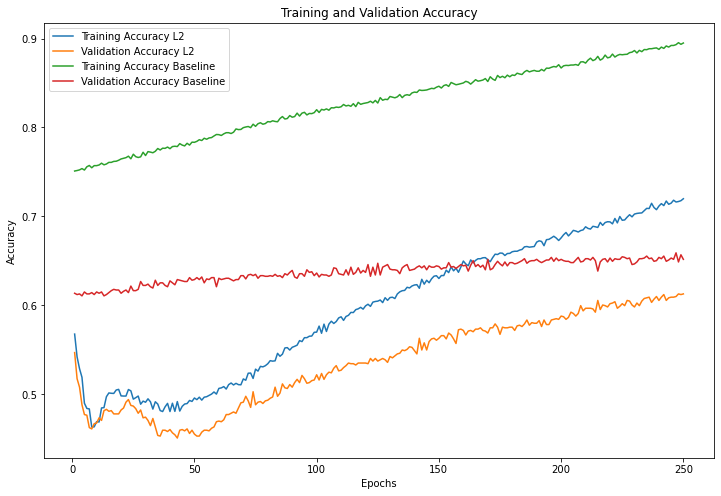

In [137]:
# look at the training and validation accuracy for baseline and l2 model
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['accuracy']
L2_val_acc_values = L2_model_dict['val_accuracy']

baseline_model_acc = baseline_model_val_dict['accuracy']
baseline_model_val_acc = baseline_model_val_dict['val_accuracy']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(acc_values)+1)
ax.plot(epochs, L2_acc_values, label='Training Accuracy L2')
ax.plot(epochs, L2_val_acc_values, label='Validation Accuracy L2')
ax.plot(epochs, baseline_model_acc, label='Training Accuracy Baseline')
ax.plot(epochs, baseline_model_val_acc, label='Validation Accuracy Baseline')
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

The results of L2 regularization are quite disappointing. The discrepancy between validation adn training accuracy seems to have decreased slightly, but the end result is definitely not getting better

In [138]:
random.seed(123)
dropout_model = models.Sequential()
dropout_model.add(layers.Dropout(0.3, input_shape=(2000,)))
dropout_model.add(layers.Dense(50, activation='relu'))
dropout_model.add(layers.Dense(25, activation='relu'))
dropout_model.add(layers.Dense(3, activation='softmax'))

In [139]:
dropout_model.compile(optimizer='SGD',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', 
                               keras.metrics.Precision(name='precision', class_id=0),
                               keras.metrics.Recall(name='recall', class_id=0)])
dropout_model_val = dropout_model.fit(X_train_tokens,
                                      y_train_lb,
                                      class_weight=weights,
                                      epochs=250,        
                                      batch_size=256,
                                      validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250
 1/22 [>.............................] - ETA: 8s - loss: 1.0479 - accuracy: 0.5820 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-03-20 14:01:13.993154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 31ms/step - loss: 1.1035 - accuracy: 0.5659 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0645 - val_accuracy: 0.5447 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/250
 1/22 [>.............................] - ETA: 0s - loss: 0.8662 - accuracy: 0.6289 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-03-20 14:01:14.655010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 14ms/step - loss: 1.1008 - accuracy: 0.5443 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0702 - val_accuracy: 0.5147 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/250
22/22 [==============================] - 0s 13ms/step - loss: 1.1013 - accuracy: 0.5307 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0753 - val_accuracy: 0.4861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/250
22/22 [==============================] - 0s 13ms/step - loss: 1.0964 - accuracy: 0.5032 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0777 - val_accuracy: 0.4699 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/250
22/22 [==============================] - 0s 13ms/step - loss: 1.0962 - accuracy: 0.4862 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0824 - val_accuracy: 0.4421 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/250
22/22 [==============================] -

22/22 [==============================] - 0s 13ms/step - loss: 0.9485 - accuracy: 0.4770 - precision: 0.2797 - recall: 0.4098 - val_loss: 0.9852 - val_accuracy: 0.4685 - val_precision: 0.2895 - val_recall: 0.3587
Epoch 73/250
22/22 [==============================] - 0s 12ms/step - loss: 0.9409 - accuracy: 0.4843 - precision: 0.2869 - recall: 0.4404 - val_loss: 0.9823 - val_accuracy: 0.4736 - val_precision: 0.2957 - val_recall: 0.3696
Epoch 74/250
22/22 [==============================] - 0s 12ms/step - loss: 0.9403 - accuracy: 0.4898 - precision: 0.2670 - recall: 0.4312 - val_loss: 0.9807 - val_accuracy: 0.4699 - val_precision: 0.2881 - val_recall: 0.3696
Epoch 75/250
22/22 [==============================] - 0s 12ms/step - loss: 0.9332 - accuracy: 0.5019 - precision: 0.2866 - recall: 0.4434 - val_loss: 0.9821 - val_accuracy: 0.4721 - val_precision: 0.2975 - val_recall: 0.3913
Epoch 76/250
22/22 [==============================] - 0s 12ms/step - loss: 0.9363 - accuracy: 0.4907 - precision:

22/22 [==============================] - 0s 12ms/step - loss: 0.7543 - accuracy: 0.5923 - precision: 0.3831 - recall: 0.7370 - val_loss: 0.8765 - val_accuracy: 0.5682 - val_precision: 0.3652 - val_recall: 0.4565
Epoch 145/250
22/22 [==============================] - 0s 13ms/step - loss: 0.7644 - accuracy: 0.5885 - precision: 0.3935 - recall: 0.7064 - val_loss: 0.8882 - val_accuracy: 0.5652 - val_precision: 0.3471 - val_recall: 0.4565
Epoch 146/250
22/22 [==============================] - 0s 12ms/step - loss: 0.7533 - accuracy: 0.5949 - precision: 0.4039 - recall: 0.7523 - val_loss: 0.8698 - val_accuracy: 0.5704 - val_precision: 0.3565 - val_recall: 0.4457
Epoch 147/250
22/22 [==============================] - 0s 12ms/step - loss: 0.7492 - accuracy: 0.5912 - precision: 0.4089 - recall: 0.7278 - val_loss: 0.8721 - val_accuracy: 0.5696 - val_precision: 0.3559 - val_recall: 0.4565
Epoch 148/250
22/22 [==============================] - 0s 12ms/step - loss: 0.7479 - accuracy: 0.5874 - precis

22/22 [==============================] - 0s 12ms/step - loss: 0.6233 - accuracy: 0.6499 - precision: 0.4948 - recall: 0.8654 - val_loss: 0.8313 - val_accuracy: 0.6019 - val_precision: 0.3277 - val_recall: 0.4239
Epoch 217/250
22/22 [==============================] - 0s 13ms/step - loss: 0.6191 - accuracy: 0.6519 - precision: 0.4956 - recall: 0.8563 - val_loss: 0.8162 - val_accuracy: 0.6092 - val_precision: 0.3714 - val_recall: 0.4239
Epoch 218/250
22/22 [==============================] - 0s 13ms/step - loss: 0.6276 - accuracy: 0.6568 - precision: 0.4946 - recall: 0.8349 - val_loss: 0.8344 - val_accuracy: 0.6026 - val_precision: 0.3305 - val_recall: 0.4239
Epoch 219/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6326 - accuracy: 0.6478 - precision: 0.4677 - recall: 0.8196 - val_loss: 0.8215 - val_accuracy: 0.6129 - val_precision: 0.3611 - val_recall: 0.4239
Epoch 220/250
22/22 [==============================] - 0s 12ms/step - loss: 0.6217 - accuracy: 0.6609 - precis

In [140]:
results_train = dropout_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \
        Training Accuracy: {results_train[1]:.3} \
        Training Precision: {results_train[2]:.3} \
        Training Recall: {results_train[3]:.3}')
print('-------------')
results_test = dropout_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \
        Test Accuracy: {results_test[1]:.3} \
        Test Precision: {results_test[2]:.3} \
        Test Recall: {results_test[3]:.3}')

171/171 [==============================] - 1s 8ms/step - loss: 0.6293 - accuracy: 0.7243 - precision: 0.6775 - recall: 0.9572
Training Loss: 0.629         Training Accuracy: 0.724         Training Precision: 0.677         Training Recall: 0.957
-------------
72/72 [==============================] - 1s 8ms/step - loss: 0.7998 - accuracy: 0.5983 - precision: 0.3896 - recall: 0.3974
Test Loss: 0.8         Test Accuracy: 0.598         Test Precision: 0.39         Test Recall: 0.397


In [141]:
find_f_score(precision=0.39, recall=0.397, beta=2)

0.39557996934082784